In [1]:
#| default_exp WAWA
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2

In [2]:
def multidimensional_fingerprint(
    A:np.ndarray, # the weighted affinity matrix
    idx:int, # the point around which to center the fingerprint,
    n_neighbors:int,
    n_dims:int,
    ) -> np.ndarray:
    """
    Given an affinity matrix A and the index i of a point therein,
    compute the multidimensional "fingerprint" diffusion.
    Whereas a single-step diffusion from the point would look the same in each direction, 
    the fingerprint assigns the values among different dimensions, sorted by direction.
    """
    
    # get nearest neighbors

    # for each point, determine its opposite.
    
    x = 8
    return x

In [3]:
# def md_diffusion_curvature(
#     A: np.ndarray, # the weighted affinity matrix
# )

# Testing the Combined Heat Kernels

In [4]:
coords_1d = np.arange(-20,20,0.05)
def heat_kernel(x,y=0,t=5,dim=1):
    return 1/((4*np.pi*t)**(dim/2)) * np.exp(-(np.linalg.norm(x - y)**2)/(4*t))

In [5]:
def riemann_integral(xs,ys):
    integral = 0
    for i in range(len(xs)-1):
        integral += ys[i]*(xs[i+1] - xs[i])
    return integral

## The product density has half the variance

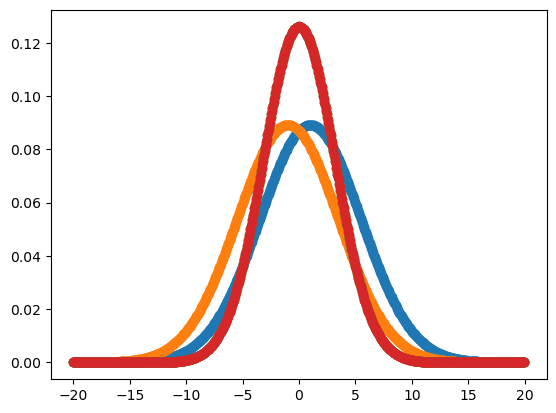

In [6]:
from functools import partial
heat_kernel_a = partial(heat_kernel,y=1,t=10)
heat_kernel_b = partial(heat_kernel,y=-1,t=10)
heat_kernel_center = partial(heat_kernel,y=0,t=5)
ys_a = np.array(list(map(heat_kernel_a,coords_1d)))
ys_b = np.array(list(map(heat_kernel_b,coords_1d)))
ys_c = list(map(heat_kernel_center,coords_1d))
ys_prod = (ys_a*ys_b)
ys_prod = ys_prod / riemann_integral(coords_1d,ys_prod)
plt.scatter(coords_1d,ys_a)
plt.scatter(coords_1d,ys_b)
plt.scatter(coords_1d,ys_prod)
plt.scatter(coords_1d,list(map(heat_kernel_center,coords_1d)))

You can't see the difference between the product and the distribution with half the time -- they are identical.

## Convolution of a heat diffusion with itself doubles the variance

In [7]:
def homemade_convolver(points):
    # Performs convolution of kernel with itself in 1d space
    results = np.zeros_like(points)
    heat_kernel_x = partial(heat_kernel,y=0,t=5)
    ys_x = np.array(list(map(heat_kernel_x,coords_1d)))
    for i in range(len(results)):
        heat_kernel_i = partial(heat_kernel,y=points[i],t=5)
        ys_i = np.array(list(map(heat_kernel_i,coords_1d)))
        results[i] += riemann_integral(points, ys_x*ys_i)
    results = results/(np.sum(results)*np.abs(points[0]-points[1]))
    return results

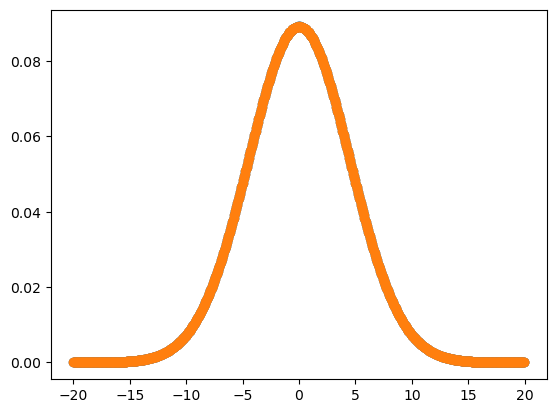

In [8]:
heat_kernel_center = partial(heat_kernel,y=0,t=10)
ys_convolved = homemade_convolver(coords_1d)
plt.scatter(coords_1d,ys_convolved)
ys_doubled = np.array(list(map(heat_kernel_center,coords_1d)))
plt.scatter(coords_1d,ys_doubled)

# Repeating with Diffusions

In [28]:
import altair as alt
import pandas as pd
df = pd.DataFrame({
    'x':coords_1d,
    'ys_convolved':ys_convolved,
    'ys_doubled':ys_doubled,
    'ys_a':ys_a,
    'ys_b':ys_b
})
alt.Chart(df).mark_line().encode(
    x = 'x',
    y = alt.Y(alt.repeat("layer"),aggregate="sum",title="y"),
    color = alt.datum(alt.repeat("layer")),
    ).repeat(layer=["ys_convolved","ys_doubled","ys_a","ys_b"])

alt.RepeatChart(...)

In [68]:
from diffusion_curvature.core import DiffusionMatrix
coords_1d = np.arange(-20,20,0.05)
def diffusion_heat_kernel(points, y = 0, t = 5, alpha = 1):
    P = DiffusionMatrix(points, kernel_type="adaptive anisotropic", alpha = alpha)
    Pt = np.linalg.matrix_power(P, t)
    return Pt[y]

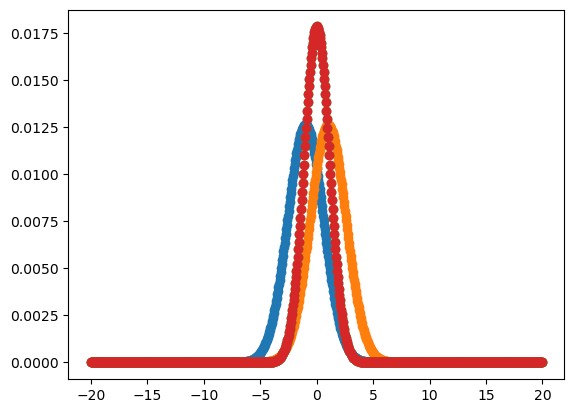

In [69]:
# testing the multiplication method
middle_y_index = len(coords_1d)//2
offset = 20
ys_a = diffusion_heat_kernel(coords_1d[:,None], y = middle_y_index - offset, alpha = 1, t = 10)
ys_b = diffusion_heat_kernel(coords_1d[:,None], y = middle_y_index + offset, alpha = 1, t = 10)
ys_mixed = ys_a * ys_b
ys_mixed /= np.sum(ys_mixed) # renormalize to sum to one
ys_center = diffusion_heat_kernel(coords_1d[:,None], y = middle_y_index, alpha = 1, t = 5)
# plot
plt.scatter(coords_1d,ys_a)
plt.scatter(coords_1d,ys_b)
plt.scatter(coords_1d,ys_center)
plt.scatter(coords_1d, ys_mixed)

It's as clear as day. It works.

How about in 2d?

In [76]:
def plot_3d(X,distribution=None, title="",lim=None, zlim=None,use_plotly=False,colorbar = False, cmap="plasma"):
    if distribution is None:
        distribution = np.zeros(len(X))
    if lim is None:
        lim = np.max(np.linalg.norm(X,axis=1))
    if use_plotly:
        d = {'x':X[:,0],'y':X[:,1],'z':X[:,2],'colors':distribution}
        df = pd.DataFrame(data=d)
        fig = px.scatter_3d(df, x='x',y='y',z='z',color='colors', title=title, range_x=[-lim,lim], range_y=[-lim,lim],range_z=[-lim,lim])
        fig.show()
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111,projection='3d')
        ax.axes.set_xlim3d(left=-lim, right=lim)
        ax.axes.set_ylim3d(bottom=-lim, top=lim)
        ax.axes.set_zlim3d(bottom=-zlim, top=zlim)
        im = ax.scatter(X[:,0],X[:,1],X[:,2],c=distribution,cmap=cmap)
        ax.set_title(title)
        if colorbar: fig.colorbar(im, ax=ax)
        plt.show()

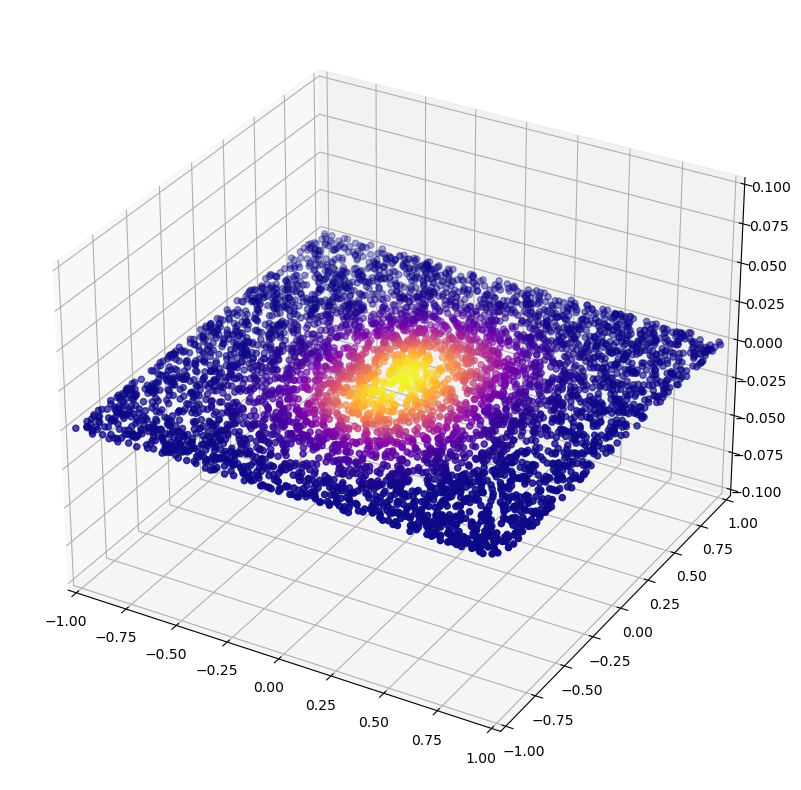

In [93]:
coords_2d = np.random.rand(5000,2)*2-1
coords_2d = np.vstack([np.zeros(2),np.array([0,0.2]),np.array([0,-0.2]),np.zeros(2),coords_2d])
t = 10
ys_a = diffusion_heat_kernel(coords_2d, y = 1, alpha = 1, t = t)
ys_b = diffusion_heat_kernel(coords_2d, y = 2, alpha = 1, t = t)
ys_mixed = ys_a * ys_b
ys_mixed /= np.sum(ys_mixed) # renormalize to sum to one
ys_center = diffusion_heat_kernel(coords_2d, y = 0, alpha = 1, t = t//2)
# plot, now in 3d
def plot_diffusion_as_3d(points,signal):
    combined_points = np.hstack([points,signal[:,None]])
    plot_3d(combined_points,signal,lim=1,zlim=0.1)
combined_signal = ys_a + ys_b
plot_diffusion_as_3d(coords_2d,combined_signal)

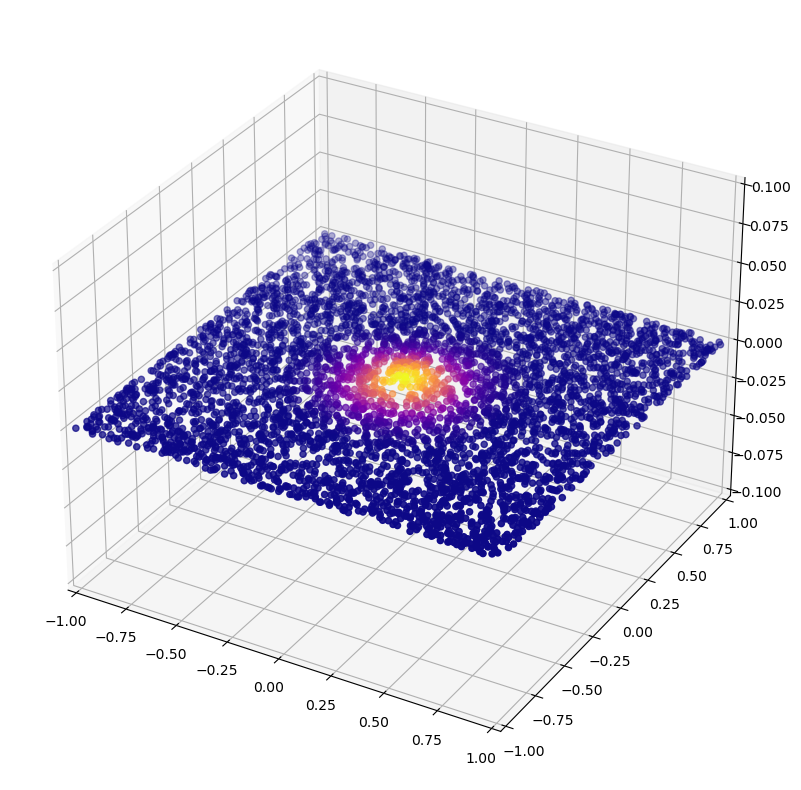

In [95]:
plot_diffusion_as_3d(coords_2d,ys_mixed)

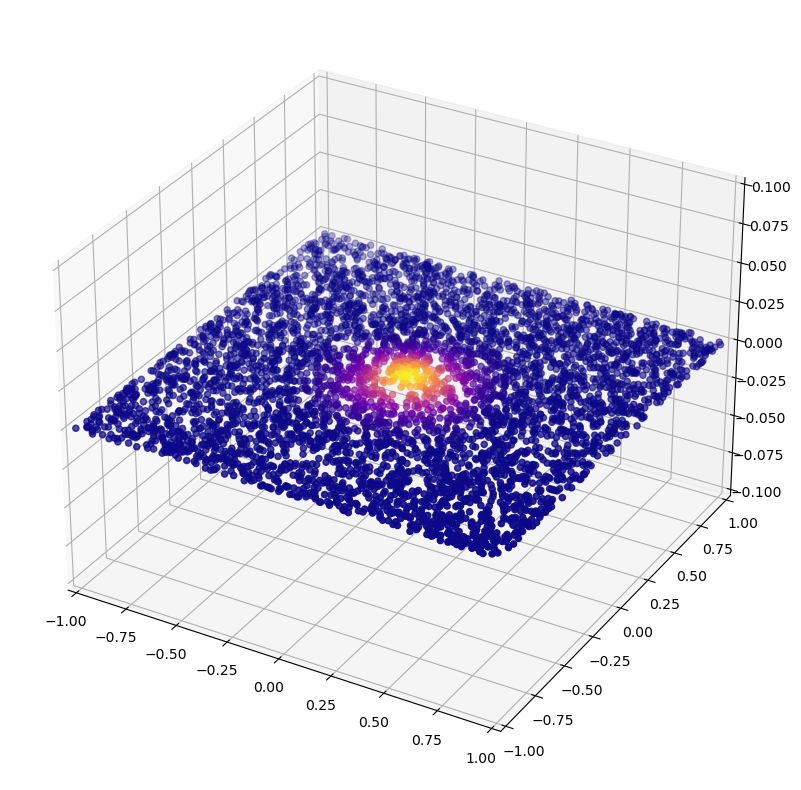

In [96]:
plot_diffusion_as_3d(coords_2d,ys_center)

There is some difference here, but *very* small.

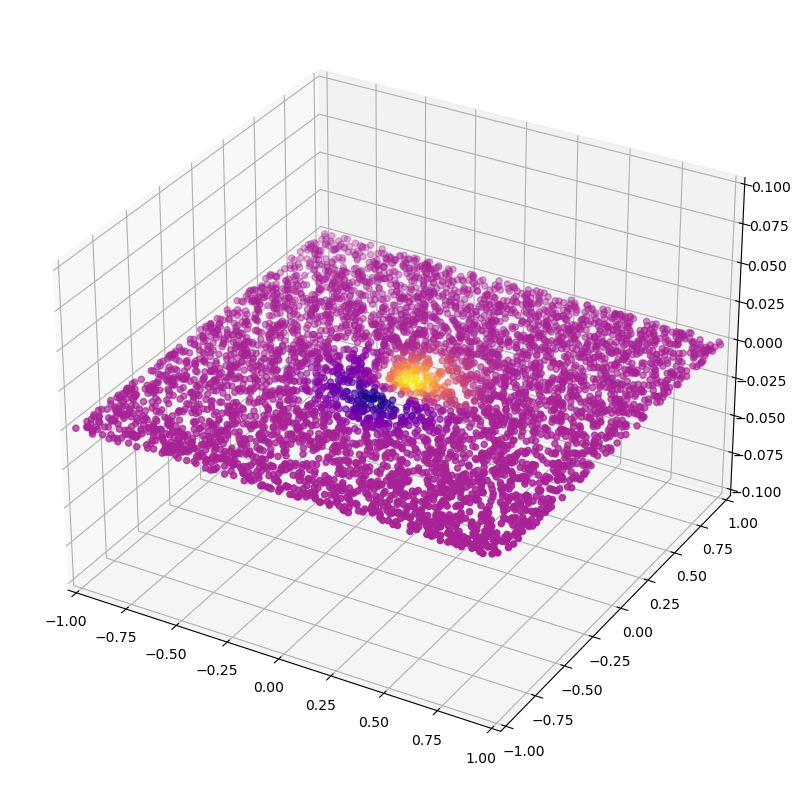

In [97]:
plot_diffusion_as_3d(coords_2d,ys_center-ys_mixed)

In [98]:
diff = ys_mixed - ys_center

In [99]:
min(diff)

-0.0009528673522653216

In [100]:
max(diff)

0.0005675806145249329

In [101]:
np.sum(diff)

2.8622937353617317e-16